In [1]:
import os, torch
from torch import nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
import numpy as np, matplotlib.pyplot as plt, pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers

# Model 1

In [2]:
# create a model class that inherits nn.Module
class Model(nn.Module):
    def __init__(self, input_features=3, h1=8, h2=9, output_features=6):
        super().__init__()
        self.fc1 = nn.Linear(input_features,h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, output_features)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

# Model 2

In [3]:
class ECGModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes_normality):
        super(ECGModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc_rpeak = nn.Linear(hidden_size, 1)  # For rpeak detection
        self.fc_normality = nn.Linear(hidden_size, num_classes_normality)  # For normality classification

    def forward(self, x):
        # LSTM layer
        x, _ = self.lstm(x)
        # x = x[:, -1, :]  # Get the last time step output

        # Output layers
        rpeak_output = torch.sigmoid(self.fc_rpeak(x))  # Sigmoid for binary classification
        normality_output = F.softmax(self.fc_normality(x), dim=1)  # Softmax for multi-class classification

        return rpeak_output, normality_output

In [4]:
torch.manual_seed(3)

# Dataframe

In [5]:
df100 = pd.read_csv('data/100.csv')
df100.columns = ['samp_num', 'MLII', 'V5']

In [6]:
df100.head()

,samp_num,MLII,V5
0,0,995,1011
1,1,995,1011
2,2,995,1011
3,3,995,1011
4,4,995,1011


# Reference

In [7]:
ref100 = pd.read_table('data/100annotations.txt',delimiter = '\t')

In [8]:
list(ref100.columns.values)

['      Time   Sample #  Type  Sub Chan  Num', 'Aux']

rpeak

In [9]:
ref100.columns = ['6', 'Sample']

normality

In [10]:
refNormal = []
refRpeak = []
for index, row in ref100.iterrows():
    if index % 500 == 0: 
        print(index)
    if ref100['6'][index].split()[2] == 'N' or ref100['6'][index].split()[2] == 'A':
        refRpeak.append(ref100['6'][index].split()[1]) 
        refNormal.append(ref100['6'][index].split()[2]) 
print('finish')

0
500
1000
1500
2000
finish


In [11]:
refRpeak[:5]

['77', '370', '662', '946', '1231']

In [12]:
refNormal[:5]

['N', 'N', 'N', 'N', 'N']

convert N to 0 and A to 1

In [13]:
refNormal = [1 if item == 'A' else 0 for item in refNormal]

In [14]:
refNormal[:5]

[0, 0, 0, 0, 0]

In [15]:
print(f"{len(refNormal)} : {len(refRpeak)}")

2272 : 2272


# add annotation data to DF

In [16]:
def add_rpeak_normality_columns(df, ref_df):
    refRpeak = []
    refNormal = []
    for index, row in ref_df.iterrows():
        if index % 500 == 0: 
            print(index)
        if ref_df['6'][index].split()[2] in ['N', 'A']:
            refRpeak.append(ref_df['6'][index].split()[1]) 
            refNormal.append(ref_df['6'][index].split()[2]) 
    print('Finish')

    refRpeak = [int(val) for val in refRpeak]

    # Create new columns in the DataFrame
    df['rpeak'] = 0
    df['normality'] = 0

    # Set 'rpeak' column values to 1 where samp_num is in refRpeak
    df.loc[df['samp_num'].isin(refRpeak), 'rpeak'] = 1

    # Set 'normality' column values based on refNormal
    for i, normal_val in enumerate(refNormal):
        if normal_val == 'N':
            df.loc[df['samp_num'] == refRpeak[i], 'normality'] = 1
        elif normal_val == 'A':
            df.loc[df['samp_num'] == refRpeak[i], 'normality'] = 0

    return df


In [17]:
df100 = add_rpeak_normality_columns(df100, ref100)

0
500
1000
1500
2000
Finish


In [18]:
df100.head()

,samp_num,MLII,V5,rpeak,normality
0,0,995,1011,0,0
1,1,995,1011,0,0
2,2,995,1011,0,0
3,3,995,1011,0,0
4,4,995,1011,0,0


# split train test

In [19]:
X = df100[['samp_num', 'MLII', 'V5']]
y = df100[['rpeak', 'normality']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train.head()

,samp_num,MLII,V5
238811,238811,987,988
9501,9501,934,960
604260,604260,929,954
118629,118629,942,995
151291,151291,955,964


In [21]:
# x to tensors long
X_train_tensor = torch.LongTensor(X_train.to_numpy()).to(torch.float)
X_test_tensor = torch.LongTensor(X_test.to_numpy()).to(torch.float)

# y to tensors long
y_train_tensor = torch.LongTensor(y_train.to_numpy()).to(torch.float)
y_test_tensor = torch.LongTensor(y_test.to_numpy()).to(torch.float)

# 1st Model testing

In [22]:
# set the citerion of model to measure the error (how off the predictions are from)
criterion = nn.MSELoss()
model = Model()

# choose Adam optimizer (lr = learning rate)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
input_size = len(X_train.columns)
output_size = len(y_train.columns)

model = Model(input_features=input_size, output_features=output_size)

## Train 1st model

In [23]:
epoch = 100
losses1 = []
for i in range(epoch):
    # prediction
    X_train_tensor = torch.FloatTensor(X_train.to_numpy())
    y_pred = model.forward(X_train_tensor)
    
    # measure loss
    loss = criterion(y_pred, y_train_tensor) #predicted value vs the y_train
    
    # track losses
    losses1.append(loss.detach().numpy())
    
    #print every 10 epoch
    if i % 10 == 0:
        print(f"Epoch{i} loss: {loss}")
        
    for param in model.parameters():
        param.requires_grad_(True)
        param.data = param.data.to(torch.float)
    
    # take error rate of forward propagation and feedback through the network to fine tune the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch0 loss: 17756696.0
Epoch10 loss: 17756696.0
Epoch20 loss: 17756696.0
Epoch30 loss: 17756696.0
Epoch40 loss: 17756696.0
Epoch50 loss: 17756696.0
Epoch60 loss: 17756696.0
Epoch70 loss: 17756696.0
Epoch80 loss: 17756696.0
Epoch90 loss: 17756696.0


I don't know why the loss is so big for the first model... let me try again.

# 2nd Model testing

In [24]:
X = df100[['MLII', 'V5']]
y_rpeak = df100['rpeak']
y_normality = df100['normality']

X_train, X_test, y_rpeak_train, y_rpeak_test, y_normality_train, y_normality_test = train_test_split(
    X, y_rpeak, y_normality, test_size=0.2, random_state=42)

In [25]:
# Convert the training and testing data to tensors
X_train_tensor = torch.tensor(X_train.values).float()
y_rpeak_train_tensor = torch.tensor(y_rpeak_train.values).float()
y_normality_train_tensor = torch.tensor(y_normality_train.values).long()  # Use .long() for classification labels

X_test_tensor = torch.tensor(X_test.values).float()
y_rpeak_test_tensor = torch.tensor(y_rpeak_test.values).float()
y_normality_test_tensor = torch.tensor(y_normality_test.values).long()

# Assuming each row in X_train is an independent observation
X_train_tensor = torch.tensor(X_train.values).float()
X_train_tensor = X_train_tensor.unsqueeze(1)  # Add a sequence dimension

In [26]:
model = ECGModel(input_size=2, hidden_size=100, num_classes_normality=len(y_normality_train.unique()))

In [27]:
criterion_rpeak = torch.nn.BCELoss()  # Binary Cross-Entropy Loss for rpeak
criterion_normality = torch.nn.CrossEntropyLoss()  # Cross-Entropy Loss for normality
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
num_epochs = 100
losses2 = []
for epoch in range(num_epochs):
    # Forward pass
    rpeak_pred, normality_pred = model(X_train_tensor)
    normality_pred = normality_pred[:, -1, :]
    
    # Compute loss
    loss_rpeak = criterion_rpeak(rpeak_pred.squeeze(), y_rpeak_train_tensor)
    loss_normality = criterion_normality(normality_pred, y_normality_train_tensor)
    loss = loss_rpeak + loss_normality  # Combine losses
    losses2.append(loss.item())
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:  # Print every 10 epochs
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [10/100], Loss: 1.2732683420181274
Epoch [20/100], Loss: 1.1597814559936523
Epoch [30/100], Loss: 1.1005232334136963
Epoch [40/100], Loss: 1.0535883903503418
Epoch [50/100], Loss: 1.0132462978363037
Epoch [60/100], Loss: 0.9788622260093689
Epoch [70/100], Loss: 0.949578046798706
Epoch [80/100], Loss: 0.9245686531066895
Epoch [90/100], Loss: 0.903131365776062
Epoch [100/100], Loss: 0.884662389755249


Text(0.5, 0, 'Epoch')

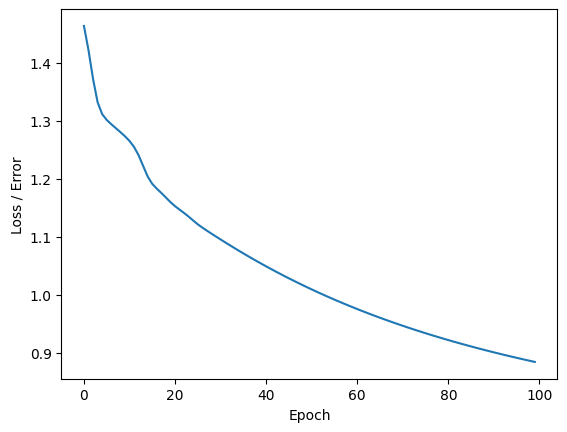

In [29]:
plt.plot(range(num_epochs), losses2)
plt.ylabel("Loss / Error")
plt.xlabel('Epoch')

## evaluation

In [30]:
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    rpeak_pred, normality_pred = model(X_test_tensor)  # X_test are features from the test set

    # Assuming you have separate loss functions for each task
    loss_rpeak = criterion_rpeak(rpeak_pred.squeeze(), y_rpeak_test_tensor)
    loss_normality = criterion_normality(normality_pred, y_normality_test_tensor)

    # You can then combine these losses if needed or handle them separately
    total_loss = loss_rpeak + loss_normality
    print (total_loss)

tensor(0.7508)


In [31]:
def evaluate_model_performance(rpeak_pred, normality_pred, y_rpeak_test, y_normality_test):
    # Assuming rpeak_pred is binary classification
    rpeak_pred_labels = torch.round(rpeak_pred.squeeze())

    # Assuming normality_pred is multi-class classification
    # Get the predicted class with the highest probability
    normality_pred_labels = torch.argmax(normality_pred, dim=1)

    # Calculate accuracy for rpeak predictions
    rpeak_accuracy = (rpeak_pred_labels == y_rpeak_test).float().mean()

    # Calculate accuracy for normality predictions
    normality_accuracy = (normality_pred_labels == y_normality_test).float().mean()

    return rpeak_accuracy.item(), normality_accuracy.item()

# Usage
rpeak_accuracy, normality_accuracy = evaluate_model_performance(rpeak_pred, normality_pred, y_rpeak_test_tensor, y_normality_test_tensor)
print(f"R-Peak Accuracy: {rpeak_accuracy * 100:.2f}%")
print(f"Normality Accuracy: {normality_accuracy * 100:.2f}%")


R-Peak Accuracy: 99.66%
Normality Accuracy: 99.67%


# TensorFlow
### Preprocessing

In [32]:
# Loading data

# Select features ('MLII' and 'V5') for X
X = df100[['MLII', 'V5']].to_numpy()

# Normalize the feature data
X = X.astype('float32') / 255

# Select labels ('rpeak' and 'normality') for y
# Using 'normality' as the label
y = df100['normality'].to_numpy()
y = to_categorical(y)

### Building

In [33]:
# Determine the number of unique classes in 'normality'
num_classes = len(np.unique(df100['normality']))

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(2,))) # 2 features: MLII, V5
network.add(layers.Dense(num_classes, activation='softmax')) # Update for your number of classes
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

### Training

In [34]:
len(X)

650000

In [74]:
x_val = X[:300000]
partial_x_train = X[300000:]
y_val = y[:300000]
partial_y_train = y[300000:]

history = network.fit(partial_x_train, 
                      partial_y_train, 
                      epochs=20, 
                      batch_size=131072, 
                      validation_data = (x_val, y_val))

Epoch 1/20
3/3 [==============================] - 0s 123ms/step - loss: 0.0052 - accuracy: 0.9975 - val_loss: 0.0054 - val_accuracy: 0.9974
Epoch 2/20
3/3 [==============================] - 0s 113ms/step - loss: 0.0051 - accuracy: 0.9976 - val_loss: 0.0062 - val_accuracy: 0.9968
Epoch 3/20
3/3 [==============================] - 0s 118ms/step - loss: 0.0054 - accuracy: 0.9975 - val_loss: 0.0055 - val_accuracy: 0.9974
Epoch 4/20
3/3 [==============================] - 0s 117ms/step - loss: 0.0052 - accuracy: 0.9975 - val_loss: 0.0055 - val_accuracy: 0.9973
Epoch 5/20
3/3 [==============================] - 0s 115ms/step - loss: 0.0052 - accuracy: 0.9975 - val_loss: 0.0053 - val_accuracy: 0.9975
Epoch 6/20
3/3 [==============================] - 0s 113ms/step - loss: 0.0054 - accuracy: 0.9974 - val_loss: 0.0062 - val_accuracy: 0.9968
Epoch 7/20
3/3 [==============================] - 0s 113ms/step - loss: 0.0053 - accuracy: 0.9975 - val_loss: 0.0054 - val_accuracy: 0.9974
Epoch 8/20
3/3 [====

## Tensorflow evaluation

In [66]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [67]:
history_dict['loss']

[0.005467068869620562,
 0.005356926005333662,
 0.005441451445221901,
 0.005386624950915575,
 0.005392661318182945,
 0.0053432960994541645,
 0.00538135040551424,
 0.00538796978071332,
 0.005313681438565254,
 0.005392372142523527,
 0.0053191655315458775,
 0.005303538870066404,
 0.005303066223859787,
 0.005322675220668316,
 0.005338998045772314,
 0.005275225732475519,
 0.005359518341720104,
 0.005260813515633345,
 0.0053245131857693195,
 0.005323887336999178]

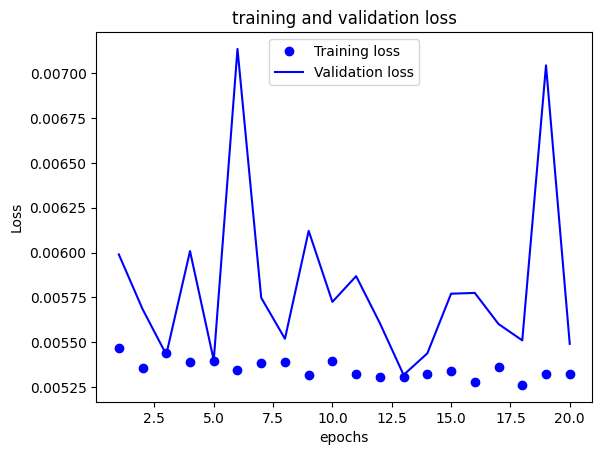

In [68]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)

blue_dots = 'bo'
solid_blue_line = 'b'

plt.plot(epochs, loss, blue_dots, label='Training loss')
plt.plot(epochs, val_loss, solid_blue_line, label='Validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

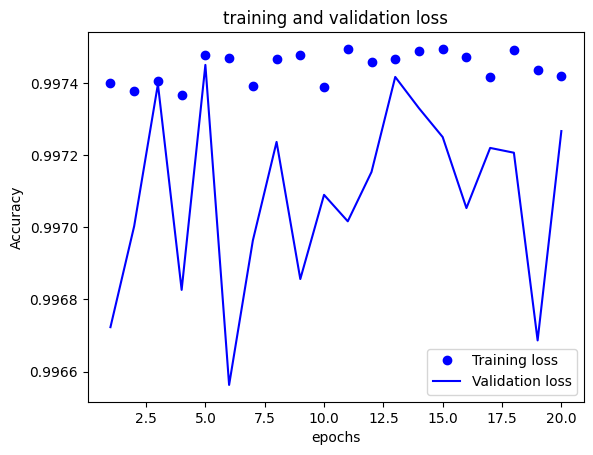

In [72]:
plt.clf()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(acc)+1)

blue_dots = 'bo'
solid_blue_line = 'b'

plt.plot(epochs, acc, blue_dots, label='Training loss')
plt.plot(epochs, val_acc, solid_blue_line, label='Validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Tensorflow Testing on unseen data

In [70]:
df101 = pd.read_csv('data/101.csv')
ref101 = pd.read_table('data/101annotations.txt',delimiter = '\t')

In [71]:
df101.columns = ['samp_num', 'MLII', 'V5']
ref101.columns = ['6', 'Sample']

In [42]:
df101 = add_rpeak_normality_columns(df101, ref101)

0
500
1000
1500
Finish


In [58]:
df101

,samp_num,MLII,V5,rpeak,normality
0,0,955,992,0,0
1,1,955,992,0,0
2,2,955,992,0,0
3,3,955,992,0,0
4,4,955,992,0,0
...,...,...,...,...,...
649995,649995,966,1004,0,0
649996,649996,965,999,0,0
649997,649997,965,1002,0,0
649998,649998,966,1002,0,0


In [43]:
X_test = df101[['MLII', 'V5']].to_numpy()
X_test = X_test.astype('float32') / 255

# Prepare labels
y_test = df101['normality'].to_numpy()
y_test = to_categorical(y_test, num_classes=num_classes)

# Model prediction
predictions = network.predict(X_test)

# Evaluate accuracy
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

accuracy = np.mean(predicted_labels == true_labels)
print("Test Accuracy: ", accuracy)

20313/20313 [==============================] - 5s 233us/step
Test Accuracy:  0.9971384615384615


# Exploring how to find Rpeak and abnormal heartbeat
## First variation function for finding Rpeak

In [44]:
def detect_r_peaks(ecg_signal, sampling_rate):
    # Derivative to highlight the QRS complex
    diff_signal = np.diff(ecg_signal)

    # Squaring to make all data points positive and emphasize larger differences
    squared_signal = diff_signal ** 2

    # Moving window integration
    window_size = int(0.12 * sampling_rate)  # 120 ms window
    integrated_signal = np.convolve(squared_signal, np.ones(window_size)/window_size, mode='same')

    # Find peaks
    peaks, _ = find_peaks(integrated_signal, distance=sampling_rate/2.5)  
    # assuming at least 0.4 seconds between heartbeats
    
    return peaks

## Second variation function for finding Rpeak

In [45]:
def detect_r_peaks2(ecg_signal, sampling_rate, threshold_factor=0.85):
    # Find local maxima
    window_size = int(0.12 * sampling_rate)  # 120 ms window, typical for adult human heart rate
    peaks = []

    for i in range(window_size, len(ecg_signal) - window_size):
        window = ecg_signal[i - window_size:i + window_size]
        if ecg_signal[i] == max(window):
            peaks.append(i)

    # Thresholding peaks
    threshold = threshold_factor * max(ecg_signal)
    r_peaks = np.array([peak for peak in peaks if ecg_signal[peak] > threshold])

    return r_peaks

## Third variation function for finding Rpeak

changed the window to 200ms based on the (2004 BioMedical Engineering OnLine Real time electrocardiogram QRS detection using combined adaptive threshold Ivaylo I Christov*) paper

In [46]:
def detect_r_peaks3(ecg_signal, sampling_rate, threshold_factor=0.85):
    # Find local maxima
    window_size = int(0.2 * sampling_rate)  # 200 ms window
    peaks = []

    for i in range(window_size, len(ecg_signal) - window_size):
        window = ecg_signal[i - window_size:i + window_size]
        if ecg_signal[i] == max(window):
            peaks.append(i)

    # Thresholding peaks
    threshold = threshold_factor * max(ecg_signal)
    r_peaks = np.array([peak for peak in peaks if ecg_signal[peak] > threshold])

    # Calculating RR intervals
    rr_intervals = np.diff(r_peaks) / sampling_rate  # Convert to seconds

    # Normality check for each R-peak based on RR intervals
    r_peak_normality = []
    if len(rr_intervals) > 0:
        mean_rr = np.mean(rr_intervals)
        # For each R-peak, check if the following RR interval is normal
        for i in range(len(r_peaks) - 1):
            is_normal = abs(rr_intervals[i] - mean_rr) < 0.20 * mean_rr
            r_peak_normality.append(is_normal)
        # The last R-peak's normality is assessed based on the last RR interval
        r_peak_normality.append(abs(rr_intervals[-1] - mean_rr) < 0.20 * mean_rr)

    return r_peaks, r_peak_normality

## Loading data and obtaining Rpeak

In [47]:
# Load the data
df = pd.read_csv('data/100.csv')
df.columns = ['samp_num', 'MLII', 'V5']

# Extract the MLII data
mlii_signal = df['MLII'].values

# Define sampling rate
sampling_rate = 360

# Detect R-peaks
r_peaks1 = detect_r_peaks(mlii_signal, sampling_rate)
r_peaks2 = detect_r_peaks2(mlii_signal, sampling_rate)

In [48]:
r_peaks3, is_normal3 = detect_r_peaks3(mlii_signal, sampling_rate)

In [49]:
r_peaks3[:5]

array([  77,  370,  663,  947, 1231])

In [50]:
is_normal3[:5]

[True, True, True, True, True]

# comparing Rpeaks:

In [51]:
peak1 = r_peaks1.tolist()
peak2 = r_peaks2.tolist()

In [52]:
r_peaks1

array([    68,    212,    360, ..., 649475, 649722, 649978])

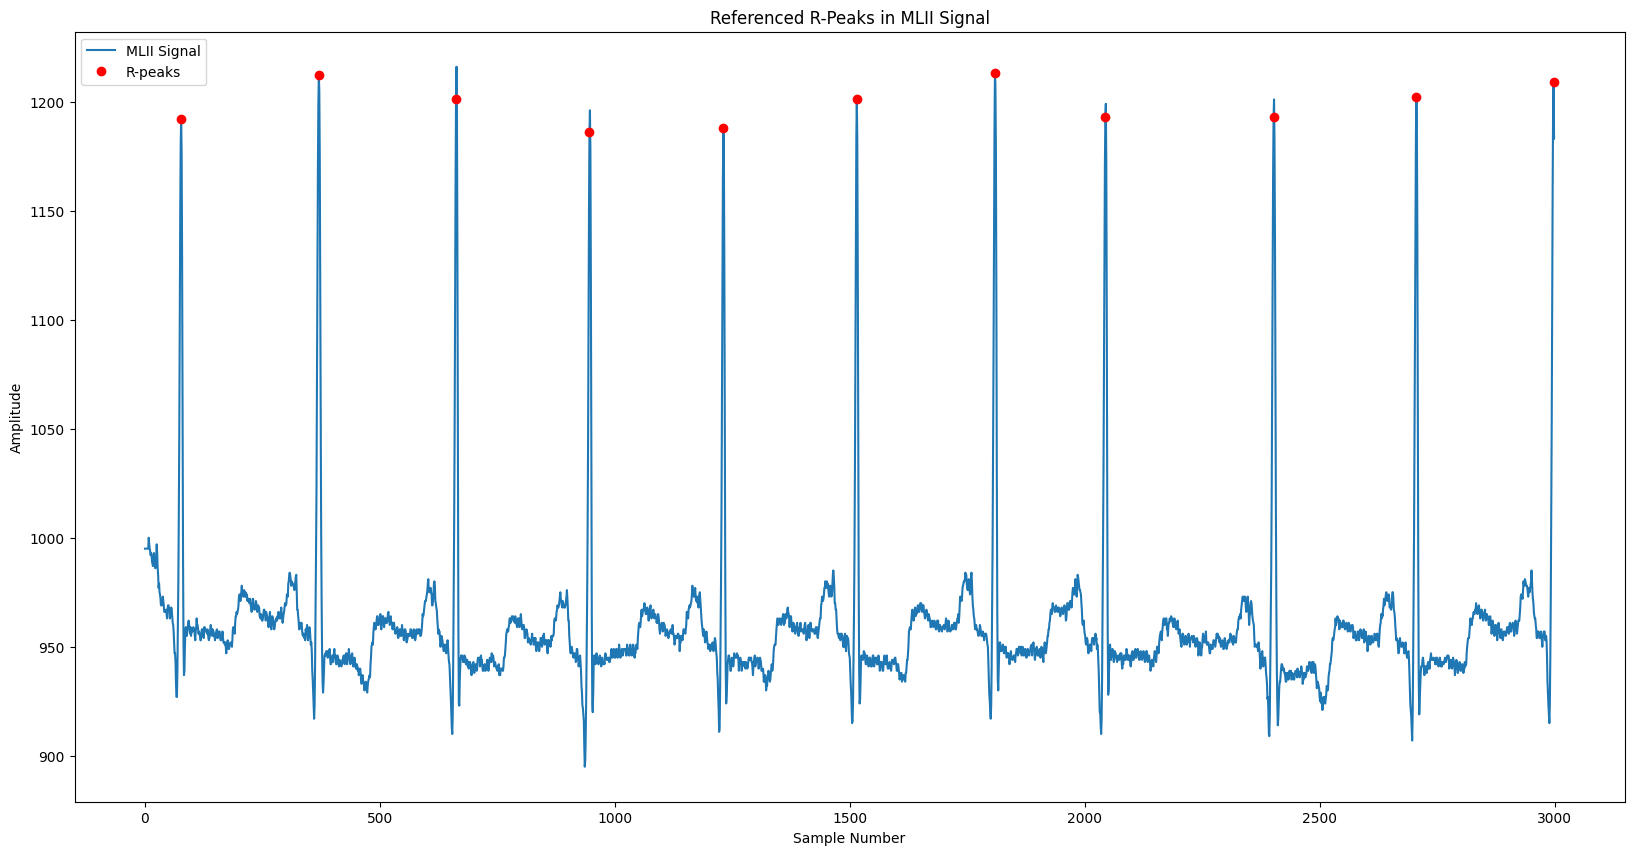

In [64]:
# Slicing the DataFrame
df_x = df100.iloc[:3000]

# Filtering R-peaks
r_peaks_x = [int(r_peak) for r_peak in refRpeak if int(r_peak) < 3000]

# Plotting
plt.figure(figsize=(20, 10))
plt.plot(df_x['samp_num'], df_x['MLII'], label='MLII Signal')

# Ensuring that the indices for R-peaks are within the range of the sliced DataFrame
valid_r_peaks_x = df_x['samp_num'].iloc[r_peaks_x]
plt.plot(valid_r_peaks_x, df_x['MLII'].iloc[r_peaks_x], 'ro', label='R-peaks')

plt.title('Referenced R-Peaks in MLII Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

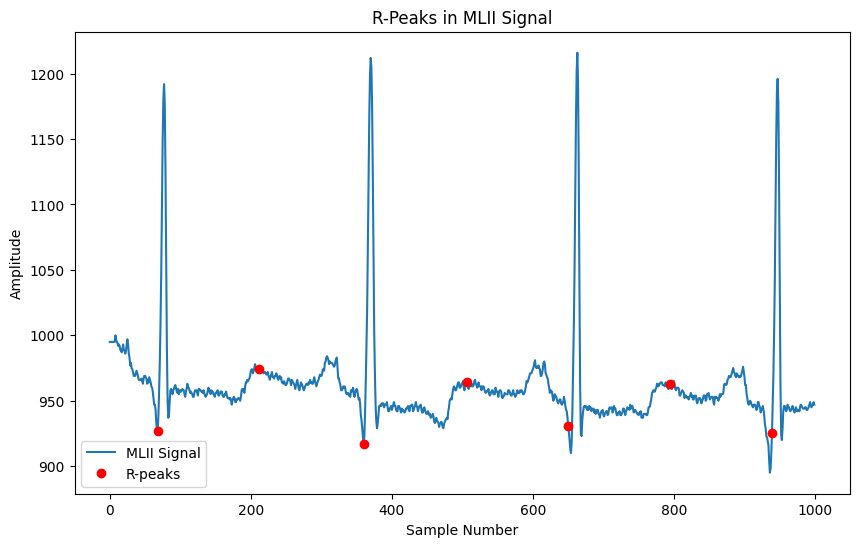

In [54]:
# Slicing the DataFrame
df_x = df.iloc[:1000]

# Filtering R-peaks
r_peaks_x = r_peaks1[r_peaks1 < 1000]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_x['samp_num'], df_x['MLII'], label='MLII Signal')
plt.plot(df_x['samp_num'][r_peaks_x], df_x['MLII'][r_peaks_x], 'ro', label='R-peaks')
plt.title('R-Peaks in MLII Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

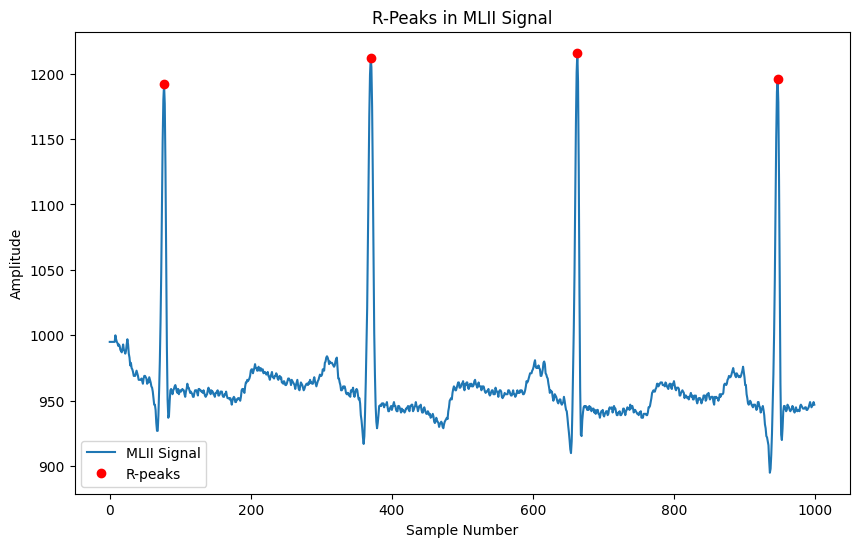

In [55]:
# Slicing the DataFrame
df_x = df.iloc[:1000]

# Filtering R-peaks
r_peaks_x = [peak for peak in r_peaks2 if peak < 1000]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_x['samp_num'], df_x['MLII'], label='MLII Signal')

# Ensuring that the indices for R-peaks are within the range of the sliced DataFrame
valid_r_peaks_x = df_x['samp_num'].iloc[r_peaks_x]
plt.plot(valid_r_peaks_x, df_x['MLII'].iloc[r_peaks_x], 'ro', label='R-peaks')

plt.title('R-Peaks in MLII Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

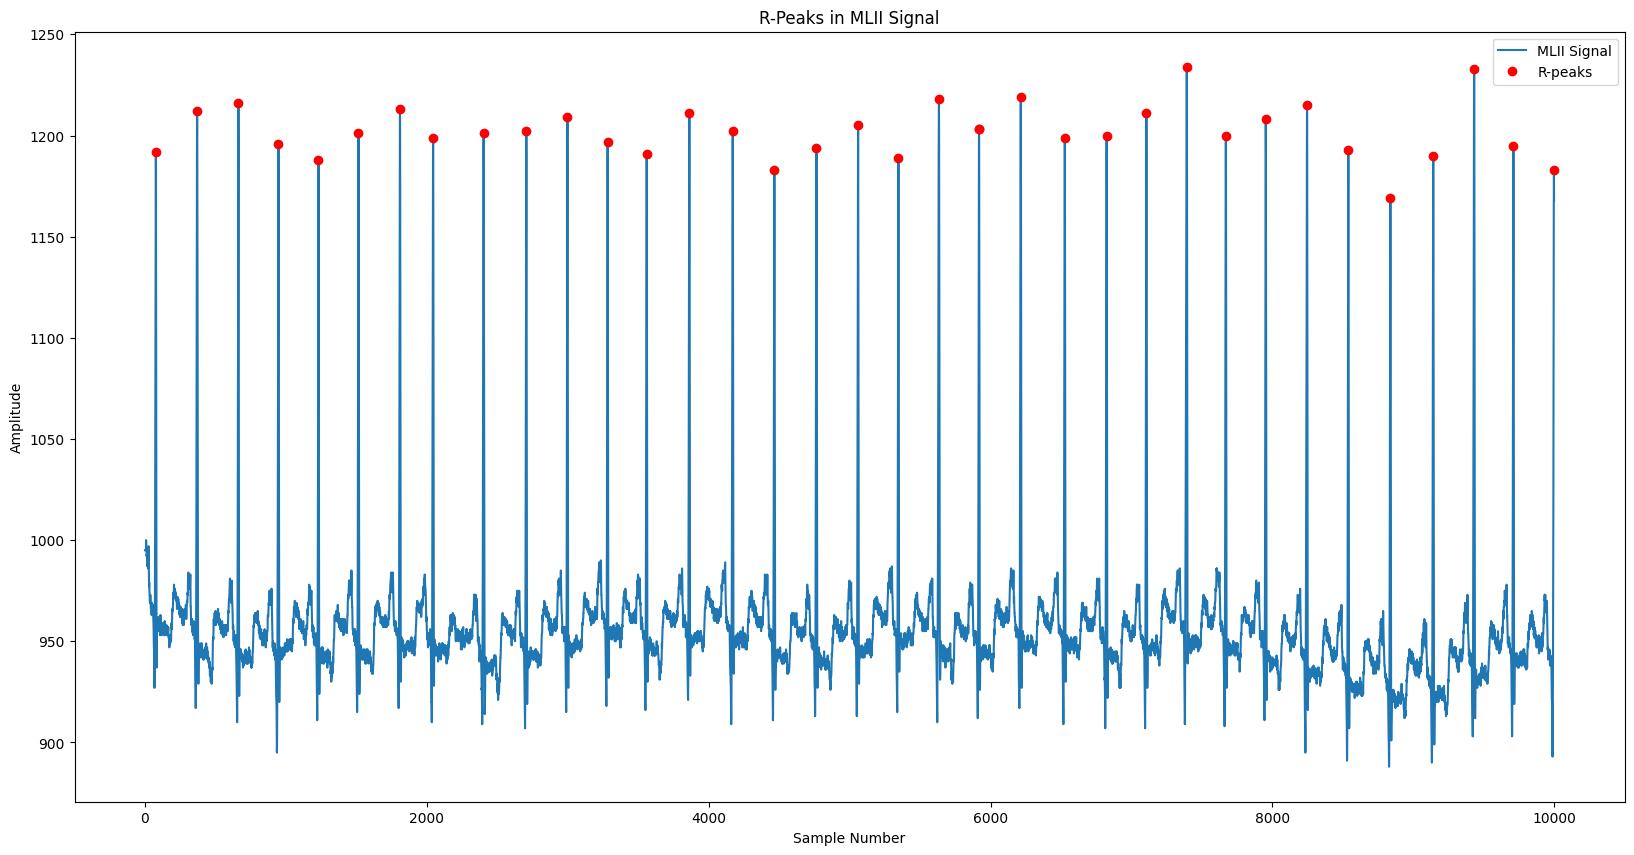

In [56]:
# Slicing the DataFrame
df_x = df.iloc[:10000]

# Filtering R-peaks
r_peaks_x = [peak for peak in r_peaks2 if peak < 10000]

# Plotting
plt.figure(figsize=(20, 10))
plt.plot(df_x['samp_num'], df_x['MLII'], label='MLII Signal')

# Ensuring that the indices for R-peaks are within the range of the sliced DataFrame
valid_r_peaks_x = df_x['samp_num'].iloc[r_peaks_x]
plt.plot(valid_r_peaks_x, df_x['MLII'].iloc[r_peaks_x], 'ro', label='R-peaks')

plt.title('R-Peaks in MLII Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

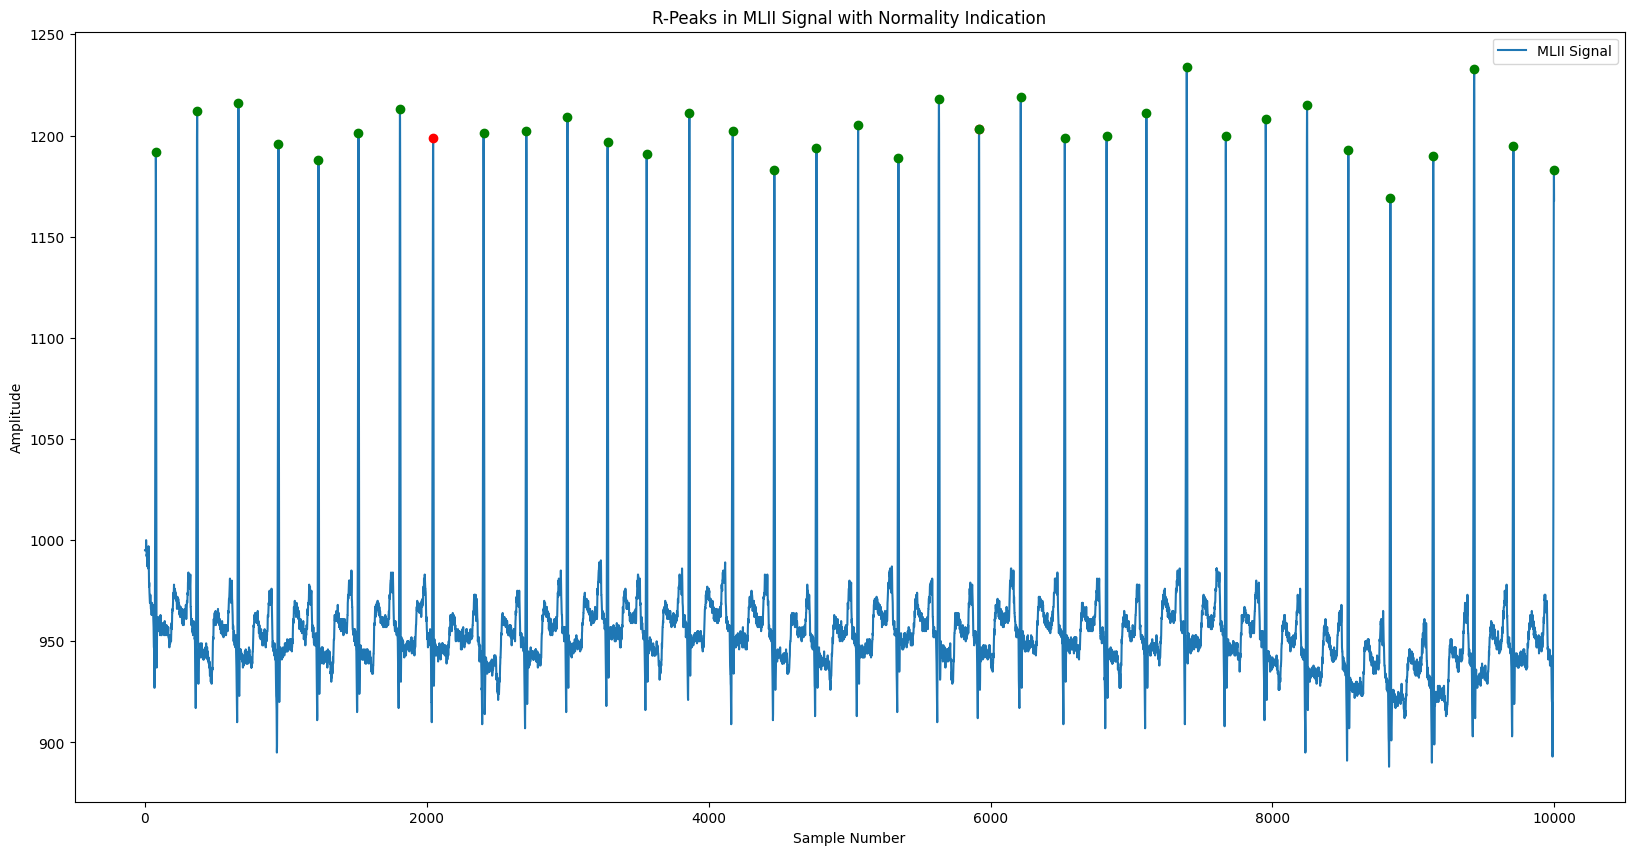

In [57]:
# Slicing the DataFrame
df_x = df.iloc[:10000]

# Filtering R-peaks
r_peaks_x = [peak for peak in r_peaks3 if peak < 10000]
# Filtering corresponding normality booleans
normality_x = is_normal3[:len(r_peaks_x)]

# Plotting
plt.figure(figsize=(20, 10))
plt.plot(df_x['samp_num'], df_x['MLII'], label='MLII Signal')

# Plotting R-peaks with color based on normality
for r_peak, is_normal3 in zip(r_peaks_x, normality_x):
    color = 'green' if is_normal3 else 'red'
    plt.plot(df_x['samp_num'].iloc[r_peak], df_x['MLII'].iloc[r_peak], 'o', color=color)

plt.title('R-Peaks in MLII Signal with Normality Indication')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()
